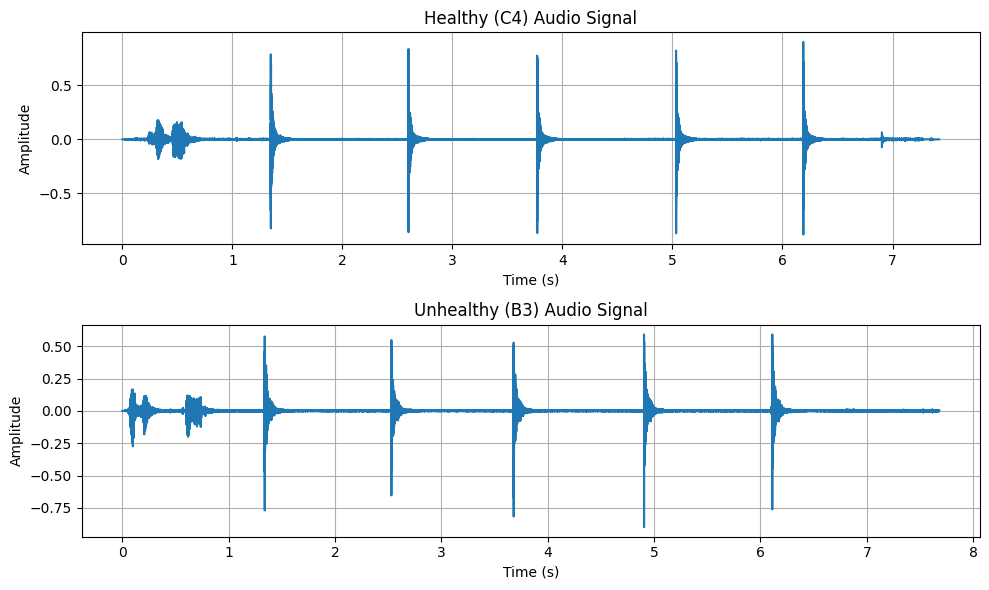

In [22]:
import librosa
import matplotlib.pyplot as plt
import numpy as np


c4_audio, sr = librosa.load("data/C4.wav", sr=48000)
b3_audio, sr = librosa.load("data/B3.wav", sr=48000)


# Plot raw audio signal



t_c4 = np.arange(len(c4_audio)) / sr
t_b3 = np.arange(len(b3_audio)) / sr
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
ax[0].plot(t_c4, c4_audio)
ax[0].set_title("Healthy (C4) Audio Signal")
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Amplitude")
ax[0].grid()
ax[1].plot(t_b3, b3_audio)
ax[1].set_title("Unhealthy (B3) Audio Signal")
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Amplitude")
ax[1].grid()
plt.tight_layout()
plt.show()


In [23]:
from scipy.signal import find_peaks

def splice_audio(audio,sr,pre_peak = 100,post_peak = 3000):
    peaks, heights = find_peaks(audio, height=0.3, distance=30000)
    print("Peaks at:", peaks)
    splices = np.array([audio[peak-pre_peak:peak+post_peak] for peak in peaks])
    print("Splices shape:", splices.shape)
    return splices
    
c4_splices = splice_audio(c4_audio, sr)
b3_splices = splice_audio(b3_audio, sr)


Peaks at: [ 64748 124821 180969 241570 297065]
Splices shape: (5, 3100)
Peaks at: [ 64252 121423 176603 235441 293333]
Splices shape: (5, 3100)


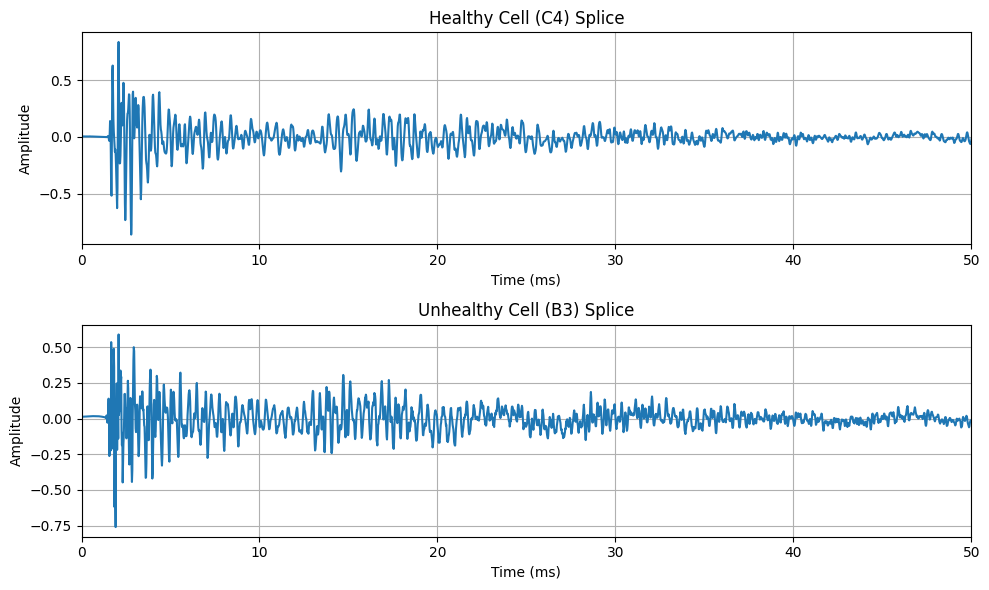

In [24]:
# Choose a healthy and unhealthy splice to plot/analyze

healthy = c4_splices[1]
unhealthy = b3_splices[4]
t_healthy = np.arange(len(healthy)) / sr
t_unhealthy = np.arange(len(unhealthy)) / sr

fig, ax = plt.subplots(2, 1, figsize=(10, 6))
ax[0].plot(1000*t_healthy, healthy)
ax[0].set_title("Healthy Cell (C4) Splice")
ax[0].set_xlabel("Time (ms)")
ax[0].set_ylabel("Amplitude")
ax[0].grid()
ax[0].set_xlim(0, 50)  # Zoom in to the first 50 ms
ax[1].plot(1000*t_unhealthy, unhealthy)
ax[1].set_title("Unhealthy Cell (B3) Splice")
ax[1].set_xlabel("Time (ms)")
ax[1].set_ylabel("Amplitude")
ax[1].grid()
ax[1].set_xlim(0, 50)  # Zoom in to the first 50 ms
plt.tight_layout()
plt.show()

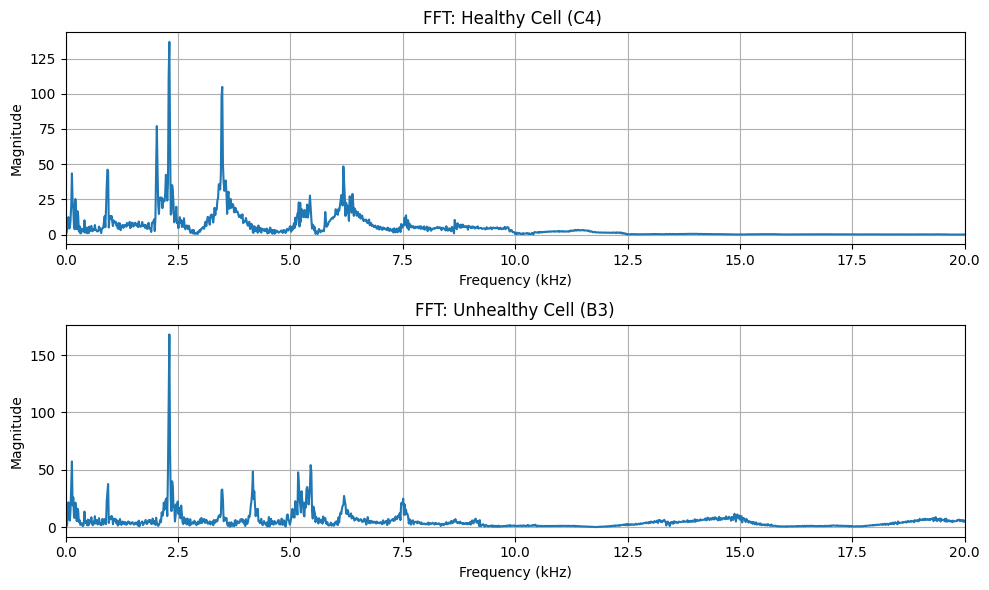

In [25]:
# FFT plots

from scipy.fft import fft, ifft 

def fftmagnitude(signal,sr):
    L = len(signal) # data length
    Y = abs(fft(signal)) # fft and normalize
    y = Y[0:L//2] # take positive frequencies
    y[2:-1] = 2*y[2:-1] # correct for amplitude
    f = np.arange(0, L//2) * sr / L # frequency axis
    return y, f

healthy_mag, healthy_freq = fftmagnitude(healthy, sr)
unhealthy_mag, unhealthy_freq = fftmagnitude(unhealthy, sr)

fig, ax = plt.subplots(2, 1, figsize=(10, 6))
ax[0].plot(healthy_freq/1000, healthy_mag)
ax[0].set_title("FFT: Healthy Cell (C4) ")
ax[0].set_xlabel("Frequency (kHz)")
ax[0].set_ylabel("Magnitude")
ax[0].grid()
ax[0].set_xlim(0, 20)  # Focus on frequencies up to 20 kHz
ax[1].plot(unhealthy_freq/1000, unhealthy_mag)
ax[1].set_title("FFT: Unhealthy Cell (B3)")
ax[1].set_xlabel("Frequency (kHz)")
ax[1].set_ylabel("Magnitude")
ax[1].grid()
ax[1].set_xlim(0, 20)  # Focus on frequencies up to 20 kHz
plt.tight_layout()
plt.show()

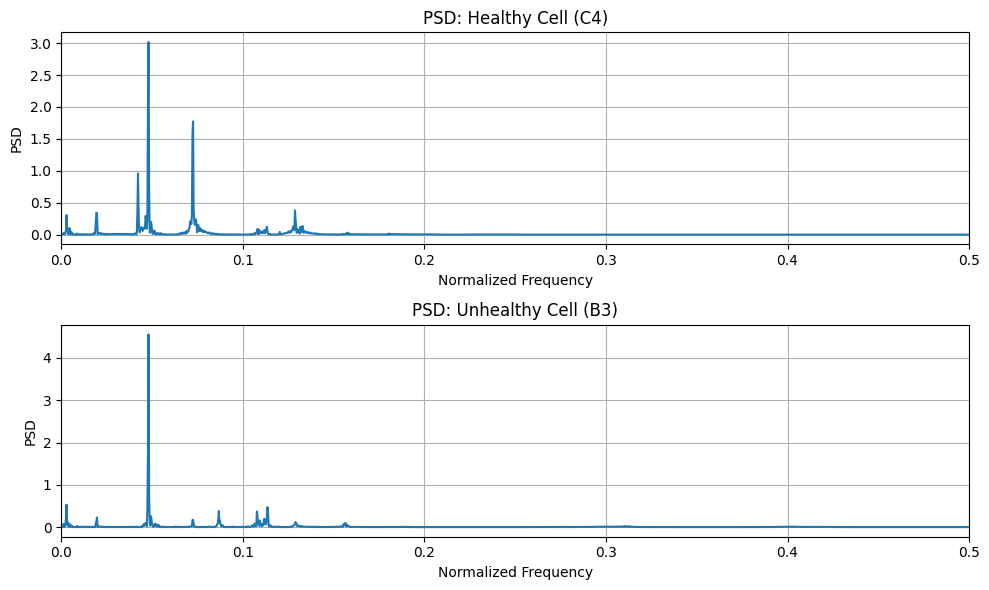

In [26]:
# PSD analysis

from scipy import signal
f_healthy, Pxx_healthy = signal.periodogram(healthy, fs=1) # set fs=1 for normalized frequency
f_unhealthy, Pxx_unhealthy = signal.periodogram(unhealthy, fs=1)

fig, ax = plt.subplots(2, 1, figsize=(10, 6))
ax[0].plot(f_healthy, Pxx_healthy)
ax[0].set_title("PSD: Healthy Cell (C4)")
ax[0].set_xlabel("Normalized Frequency")
ax[0].set_ylabel("PSD")
ax[0].grid()
ax[0].set_xlim(0, 0.5)  # Focus on normalized frequencies up to Nyquist (0.5)
ax[1].plot(f_unhealthy, Pxx_unhealthy)
ax[1].set_title("PSD: Unhealthy Cell (B3)")
ax[1].set_xlabel("Normalized Frequency")
ax[1].set_ylabel("PSD")
ax[1].grid()
ax[1].set_xlim(0, 0.5)  # Focus on normalized frequencies up to Nyquist (0.5)
plt.tight_layout()
plt.show()


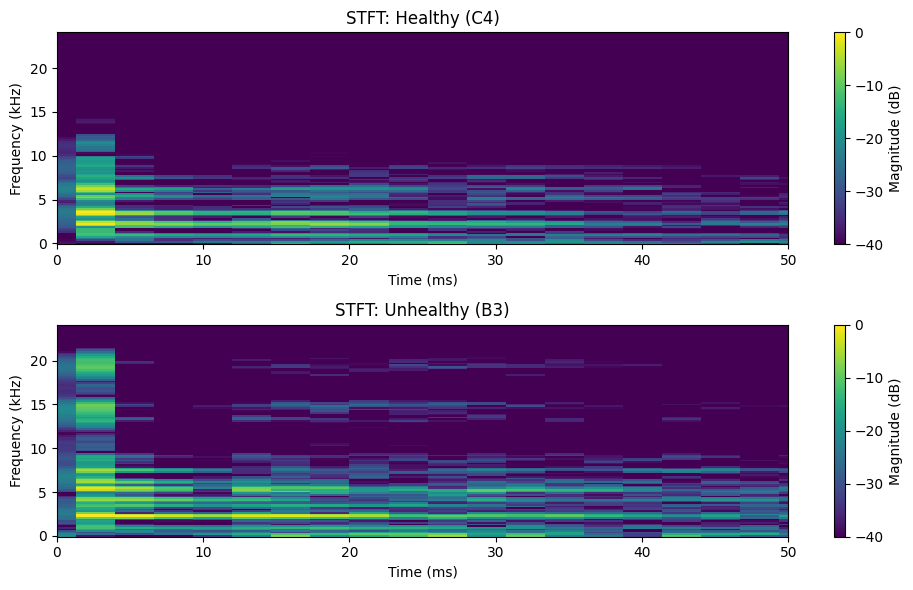

In [27]:
# STFT Analysis
f_healthy_stft, t_healthy_stft, Zxx_healthy = signal.stft(healthy, fs=sr, nperseg=256)
f_unhealthy_stft, t_unhealthy_stft, Zxx_unhealthy = signal.stft(unhealthy, fs=sr, nperseg=256)
Zxx_healthy_db = 20 * np.log10(np.abs(Zxx_healthy))
Zxx_unhealthy_db = 20 * np.log10(np.abs(Zxx_unhealthy))
Zxx_healthy_db_normalized = Zxx_healthy_db - np.max(Zxx_healthy_db)  # peak becomes 0 dB, everything else is negative
Zxx_unhealthy_db_normalized = Zxx_unhealthy_db - np.max(Zxx_unhealthy_db)  # peak becomes 0 dB, everything else is negative

fig, ax = plt.subplots(2, 1, figsize=(10, 6))
ax[0].pcolormesh(1000*t_healthy_stft, f_healthy_stft/1000, Zxx_healthy_db_normalized, shading='nearest', vmin=-40, vmax=0)  # Limit color range to -60 dB to 0 dB
ax[0].set_title("STFT: Healthy (C4)")
ax[0].set_xlabel("Time (ms)")
ax[0].set_ylabel("Frequency (kHz)")
ax[0].set_xlim(0, 50)  # Focus on the first 50 ms
ax[1].pcolormesh(1000*t_unhealthy_stft, f_unhealthy_stft/1000, Zxx_unhealthy_db_normalized, shading='nearest', vmin=-40, vmax=0)
ax[1].set_title("STFT: Unhealthy (B3)")
ax[1].set_xlabel("Time (ms)")
ax[1].set_ylabel("Frequency (kHz)")
ax[1].set_xlim(0, 50)  # Focus on the first 50 ms
plt.tight_layout()
plt.colorbar(ax[0].collections[0], ax=ax[0], label='Magnitude (dB)')
plt.colorbar(ax[1].collections[0], ax=ax[1], label='Magnitude (dB)')
plt.show()

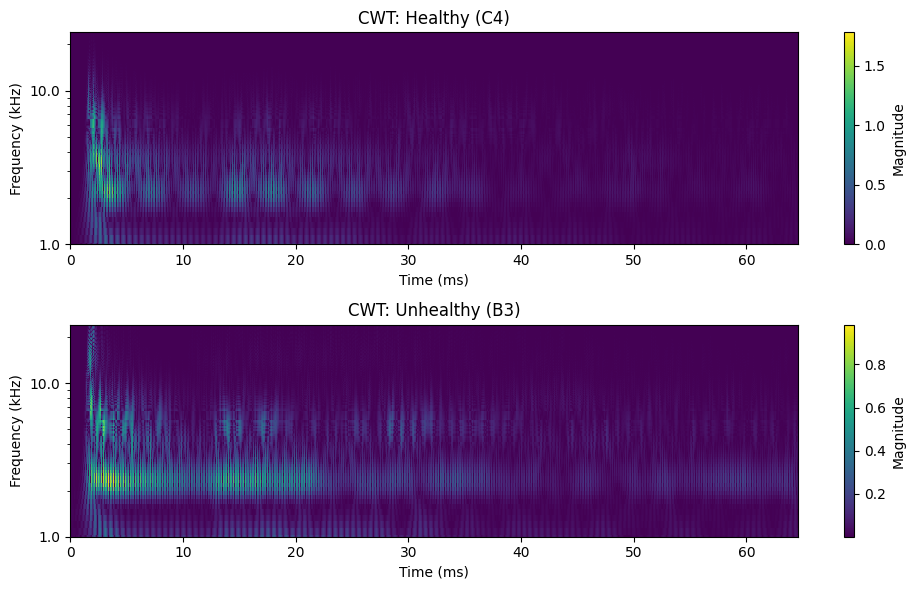

In [28]:
# CWT Analysis

import pywt
from matplotlib.ticker import ScalarFormatter

wavelet = pywt.ContinuousWavelet('morl')
fc = pywt.central_frequency(wavelet)

frequencies = np.linspace(1, sr/2, 200)
scales = fc / (frequencies * (1/sr))
coeffs_healthy, _ = pywt.cwt(healthy, scales, wavelet, sampling_period=1/sr)
coeffs_unhealthy, _ = pywt.cwt(unhealthy, scales, wavelet, sampling_period=1/sr)




fig, ax = plt.subplots(2, 1, figsize=(10, 6))
ax[0].pcolormesh(1000*t_healthy, frequencies/1000, np.abs(coeffs_healthy), shading='nearest')
ax[0].set_title("CWT: Healthy (C4)")
ax[0].set_xlabel("Time (ms)")
ax[0].set_ylabel("Frequency (kHz)")
ax[0].set_yscale('log')
ax[0].set_ylim(1, sr/2000)  # Focus on frequencies up to Nyquist (24 kHz)
ax[1].pcolormesh(1000*t_unhealthy, frequencies/1000, np.abs(coeffs_unhealthy), shading='nearest')
ax[1].set_title("CWT: Unhealthy (B3)")
ax[1].set_xlabel("Time (ms)")
ax[1].set_ylabel("Frequency (kHz)")
ax[1].set_yscale('log')
ax[1].set_ylim(1, sr/2000)  # Focus on frequencies up to Nyquist (24 kHz)

ax[0].yaxis.set_major_formatter(ScalarFormatter())
ax[0].yaxis.get_major_formatter().set_scientific(False)
ax[1].yaxis.set_major_formatter(ScalarFormatter())
ax[1].yaxis.get_major_formatter().set_scientific(False)

plt.tight_layout()
plt.colorbar(ax[0].collections[0], ax=ax[0], label='Magnitude')
plt.colorbar(ax[1].collections[0], ax=ax[1], label='Magnitude')
plt.show()





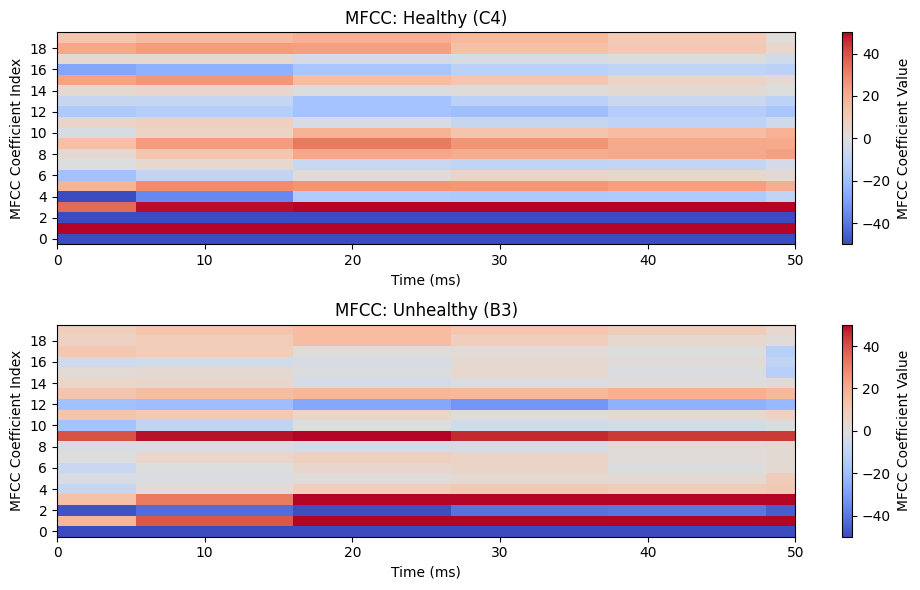

In [30]:
# MFCC Analysis
mfcc_healthy = librosa.feature.mfcc(y=healthy, sr=sr) # feature matrices
mfcc_unhealthy = librosa.feature.mfcc(y=unhealthy, sr=sr)


fig, ax = plt.subplots(2, 1, figsize=(10, 6))


img1 = librosa.display.specshow(mfcc_healthy, sr=sr, x_axis='time', ax=ax[0], vmin=-50, vmax=50)
ax[0].set_title("MFCC: Healthy (C4)")
plt.colorbar(img1, ax=ax[0], label='MFCC Coefficient Value')

ax[0].set_xlabel("Time (ms)")
# convert current tick labels from seconds to ms
ticks = ax[0].get_xticks()
ax[0].set_xticks(ticks)
ax[0].set_xticklabels([f"{t*1000:.0f}" for t in ticks])
ax[0].set_xlim(0, 50/1000)  # Focus on the first 50 ms
ax[0].set_ylabel("MFCC Coefficient Index")
ax[0].set_yticks(range(0, 20, 2))  # 0, 2, 4, ... 18
ax[0].set_yticklabels(range(0, 20, 2))

img2 = librosa.display.specshow(mfcc_unhealthy, sr=sr, x_axis='time', ax=ax[1], vmin=-50, vmax=50)
ax[1].set_title("MFCC: Unhealthy (B3)")
plt.colorbar(img2, ax=ax[1], label='MFCC Coefficient Value')
ax[1].set_xlabel("Time (ms)")
# convert current tick labels from seconds to ms
ticks = ax[1].get_xticks()
ax[1].set_xticks(ticks)
ax[1].set_xticklabels([f"{t*1000:.0f}" for t in ticks])
ax[1].set_xlim(0, 50/1000)  # Focus on the first 50 ms
ax[1].set_ylabel("MFCC Coefficient Index")
ax[1].set_yticks(range(0, 20, 2))  # 0, 2, 4, ... 18
ax[1].set_yticklabels(range(0, 20, 2))

plt.tight_layout()
plt.show()
